# Stereoisomer testing on ChiENN - stellungsisomere

## Importing section

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys
sys.path.append("../../")
sys.path.append("ChiENN-master")
from ptgnn.features.chienn.molecule3d import smiles_to_data_with_circle_index
from ptgnn.model.chienn.chienn_layer import ChiENNLayer
from ptgnn.loading.chienn_collate import collate_with_circle_index

## Define SMILES strings

In [2]:
smiles_list = [
    "CC(Cl)(Cl)C",
    "C(Cl)C(Cl)C",
    "ClCCCCl",
    
    "OC(=O)C(N)CC",
    "OC(=O)CC(N)C",
    "OC(=O)CCCN",
    
    "C1C=CC=C(Cl)C=1Cl",
    "ClC1C=CC=C(Cl)C=1",
    "ClC1C=CC(Cl)=CC=1",
]

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

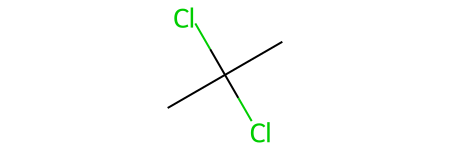

[]


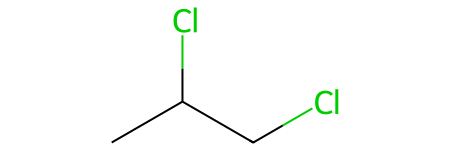

[]


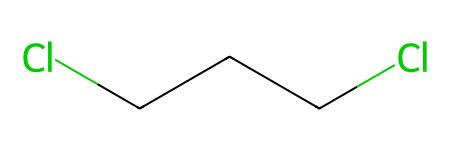

[]


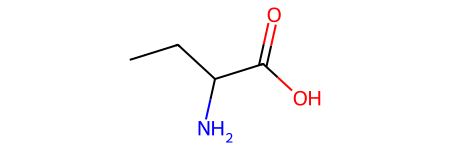

[]
Bond 1 stereo: STEREONONE


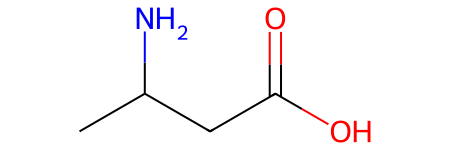

[]
Bond 1 stereo: STEREONONE


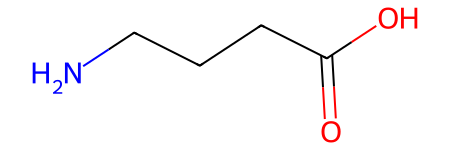

[]
Bond 1 stereo: STEREONONE


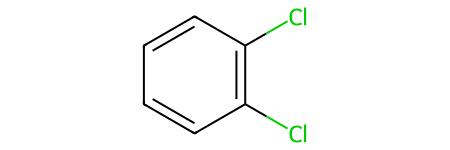

[]


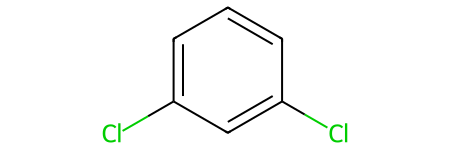

[]


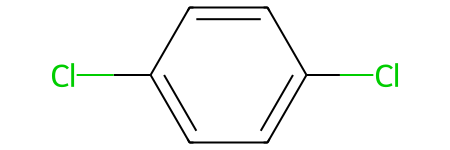

[]


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph

In [5]:
data_list = [
    smiles_to_data_with_circle_index(smiles)
    for smiles in smiles_list
]

In [6]:
for data in data_list:
    print(data)
    print(data.circle_index)

Data(x=[20, 93], edge_index=[2, 56], edge_attr=[56, 57], parallel_node_index=[20], circle_index=[20])
[[3, 7, 5], [9, 11, 13], [1, 5, 7], [], [1, 7, 3], [], [1, 3, 5], [], [0, 13, 11], [15, 19, 17], [0, 9, 13], [], [0, 11, 9], [], [8, 17, 19], [], [8, 19, 15], [], [8, 15, 17], []]
Data(x=[20, 93], edge_index=[2, 56], edge_attr=[56, 57], parallel_node_index=[20], circle_index=[20])
[[3, 5, 7], [9, 11, 13], [1, 7, 5], [], [1, 3, 7], [], [1, 5, 3], [], [0, 13, 11], [], [0, 9, 13], [15, 19, 17], [0, 11, 9], [], [10, 17, 19], [], [10, 19, 15], [], [10, 15, 17], []]
Data(x=[20, 93], edge_index=[2, 56], edge_attr=[56, 57], parallel_node_index=[20], circle_index=[20])
[[], [3, 7, 5], [0, 5, 7], [9, 11, 13], [0, 7, 3], [], [0, 3, 5], [], [2, 13, 11], [15, 19, 17], [2, 9, 13], [], [2, 11, 9], [], [8, 17, 19], [], [8, 19, 15], [], [8, 15, 17], []]
Data(x=[30, 93], edge_index=[2, 80], edge_attr=[80, 57], parallel_node_index=[30], circle_index=[30])
[[3, 5, 7], [9, 13, 11], [1, 7, 5], [], [1, 3, 7]

## Create Model

In [7]:
k = 3
model = ChiENNLayer(
    hidden_dim=93,
    k_neighbors_embeddings_names=['linear']*k
)
model

ChiENNLayer(
  (message): ChiENNMessage(
    (embeddings_list): ModuleList(
      (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
    )
    (final_embedding): Sequential(
      (0): ELU(alpha=1.0)
      (1): Linear(in_features=93, out_features=93, bias=False)
    )
  )
  (aggregate): ChiENNAggregate(
    (self_embedding): Linear(in_features=93, out_features=93, bias=False)
    (parallel_embedding): Linear(in_features=93, out_features=93, bias=False)
    (post_aggregation_embedding): ELU(alpha=1.0)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

## Create batches

In [8]:
batch_list = [
    collate_with_circle_index([data], k)
    for data in data_list
]

## Put batches through model

In [9]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [10]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all() if out_list[i].shape==out_list[j].shape else False
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True, False, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False],
       [False, False, False, False, False,  True, False, False, False],
       [False, False, False, False, False, False,  True, False, False],
       [False, False, False, False, False, False, False,  True, False],
       [False, False, False, False, False, False, False, False,  True]])

In [11]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False],
       [False, False, False, False, False,  True, False, False, False],
       [False, False, False, False, False, False,  True, False, False],
       [False, False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False,  True,  True]])

Distinguishes properly (twice equal value - repeated until different)